Brain tumor Detection using MobileNetV2 model

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
DATA_PATH = 'C:/Users/junjo/Documents/python/projects/brain_tumor_detection/dataset'

In [12]:
# Data augmentation with medical imaging best practices
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    brightness_range=[0.9, 1.1]
)

In [13]:
# Binary classification data generators
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [14]:
# Verify dataset configuration
print("\nDataset Configuration:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")


Dataset Configuration:
Training samples: 2400
Validation samples: 600
Class indices: {'no': 0, 'yes': 1}


In [15]:
# MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze base model layers
base_model.trainable = False

# Custom model architecture
model = models.Sequential([
    base_model,
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])


In [16]:
# Custom learning rate schedule
def lr_schedule(epoch):
    initial_lr = 1e-5
    if epoch > 20:
        return initial_lr * 0.1
    return initial_lr

In [17]:
# Model compilation
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [18]:
# Callbacks
callbacks = [
    EarlyStopping(
        patience=10,
        monitor='val_auc',
        mode='max',
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_recall',
        mode='max',
        save_best_only=True
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

In [19]:
# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.4813 - auc: 0.4927 - loss: 0.8715 - precision: 0.4659 - recall: 0.4911 - val_accuracy: 0.5683 - val_auc: 0.6677 - val_loss: 0.6742 - val_precision: 0.6565 - val_recall: 0.2867 - learning_rate: 1.0000e-05
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5514 - auc: 0.5812 - loss: 0.7798 - precision: 0.5474 - recall: 0.5661 - val_accuracy: 0.6483 - val_auc: 0.7120 - val_loss: 0.6217 - val_precision: 0.6519 - val_recall: 0.6367 - learning_rate: 1.0000e-05
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6306 - auc: 0.6638 - loss: 0.6940 - precision: 0.6323 - recall: 0.6405 - val_accuracy: 0.7300 - val_auc: 0.8088 - val_loss: 0.5627 - val_precision: 0.7006 - val_recall: 0.8033 - learning_rate: 1.0000e-05
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.6388 - auc: 0.6803 - loss: 0.6781 - precision: 0.6475 - recall: 0.6434 - val_accuracy: 0.7617 - val_auc: 0.8523 - val_loss: 0.52

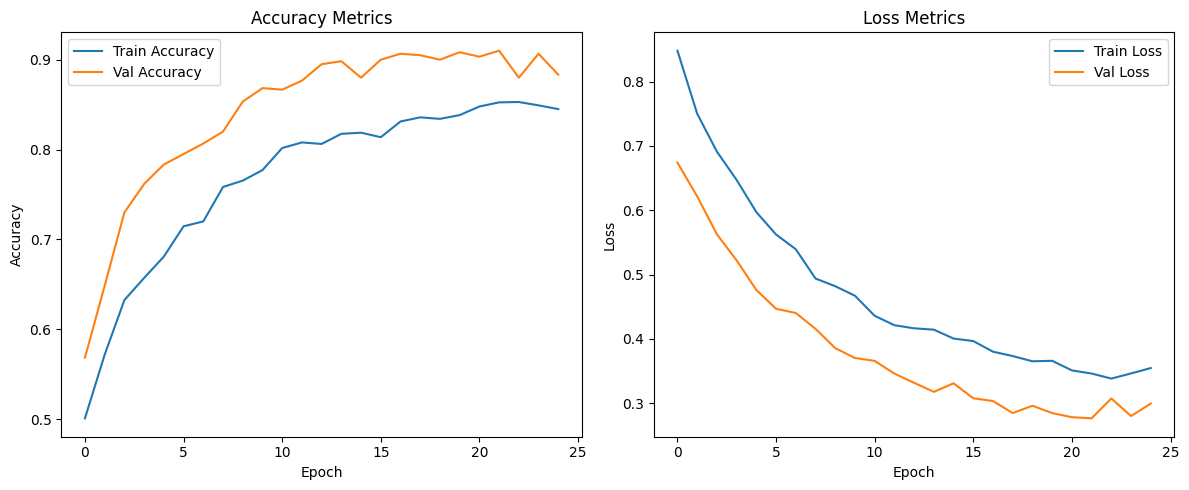

In [23]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Metrics')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Metrics')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)


Validation Set Evaluation:
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step   
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       300
           1       0.92      0.91      0.91       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600


Confusion Matrix:
[[276  24]
 [ 28 272]]


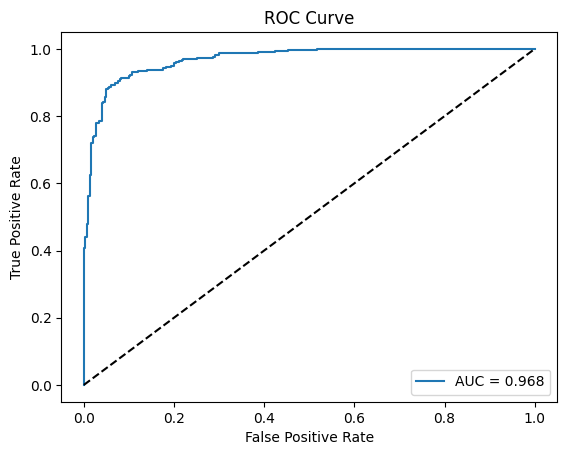

In [52]:
def evaluate_model(model, generator, threshold=0.5):
    # True labels
    y_true = generator.classes

    # Predicted probabilities for the positive class
    y_prob = model.predict(generator).ravel()

    # Binary predictions by thresholding
    y_pred = (y_prob > threshold).astype(int)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # ROC curve + AUC
    fpr, tpr, thresh = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

print("\nValidation Set Evaluation:")
evaluate_model(model, val_generator)

In [38]:
# Prediction function with confidence
def predict_tumor(img_path, threshold=0.6):
    img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    
    prob = model.predict(x)[0][0]
    confidence = prob if prob > threshold else 1 - prob
    return {
        'prediction': 'Tumor Detected' if prob > threshold else 'No Tumor',
        'confidence': f"{confidence:.2%}",
        'probability': prob
    }

In [44]:
# Example usage
test_image = 'C:/Users/junjo/Documents/python/projects/brain_tumor_detection/test_data/pred/pred30.jpg'
result = predict_tumor(test_image)
print("\nPrediction Result:")
print("Diagnosis:", result['prediction'])
print("Confidence:" , result['confidence'])
print("Raw Probability:" f"{result['probability']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

Prediction Result:
Diagnosis: Tumor Detected
Confidence: 83.50%
Raw Probability:0.8350
